In [1]:
import os
os.environ['JAVA_HOME']='/usr/bin/java'

In [2]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from capymoa.stream import Stream, Schema, NumpyStream
from capymoa.classifier import HoeffdingAdaptiveTree
from capymoa.regressor import FIMTDD
from capymoa.instance import Instance, LabeledInstance
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results, plot_predictions_vs_ground_truth
from capymoa.misc import save_model, load_model

import matplotlib.pyplot as plt

In [ ]:
class StationRecommendationSystem:
    """
    Dynamic Station Recommendation System Based on Real-time Passenger Flow Data
    Using CapyMOA Online Learning Algorithm for Busy Station Detection and Alternative Station Recommendation
    """
    def __init__(self, data_path_5min, data_path_30min):
        self.data_path_5min = data_path_5min
        self.data_path_30min = data_path_30min
        
        self.busy_detector = None
        self.demand_predictor = None
    
        # Busy station threshold (top 20%)
        self.busy_threshold_percentile = 80

        # Recommendation radius (1 km)
        self.recommendation_radius = 1000    

        # Station Information
        self.stations = []
        self.station_data = None
        self.station_locations = {}
        self.boarding_5min = None
        self.landing_5min = None
        self.loader_5min = None
        self.boarding_30min = None
        self.landing_30min = None
        self.loader_30min = None
        
        # Results storage
        self.results = None

    def _initialize_models(self):
        """
        Initialize models
        """
        
        # Features include: current boarding count, alighting count, onboard count, hour, day of week, is weekend, historical statistics, etc.
        schema = Schema.from_custom(
            feature_names=[
                "boarding", "landing", "loader",
                "hour", "day_of_week", "is_weekend",
                "nearby_flow",
            ],
            dataset_name="BusStop",
            target_attribute_name="is_busy",
            values_for_class_label=[0, 1]
        )

        # Initialize model
        self.busy_detector = HoeffdingAdaptiveTree(schema)  # Busy station detection
        self.demand_predictor = FIMTDD(schema)  # Demand prediction

    def load_and_preprocess_data(self):
        """
        Load and preprocess 5-minute and 30-minute data
        """
        print("Loading data...")
        
        # Load 5-minute data
        self.boarding_5min = pd.read_csv(f"{self.data_path_5min}/boarding_03-05_2024.csv", index_col=0)
        self.landing_5min = pd.read_csv(f"{self.data_path_5min}/landing_03-05_2024.csv", index_col=0)
        self.loader_5min = pd.read_csv(f"{self.data_path_5min}/loader_03-05_2024.csv", index_col=0)
        
        # Load 30-minute data
        self.boarding_30min = pd.read_csv(f"{self.data_path_30min}/boarding_03-05_2024.csv", index_col=0)
        self.landing_30min = pd.read_csv(f"{self.data_path_30min}/landing_03-05_2024.csv", index_col=0)
        self.loader_30min = pd.read_csv(f"{self.data_path_30min}/loader_03-05_2024.csv", index_col=0)

        # Load station information
        self.station_data = pd.read_csv("BusStops.csv")
        self.station_data.set_index('stop_id', inplace=True)
        
        # Convert time index
        for df in [self.boarding_5min, self.landing_5min, self.loader_5min]:
            df.index = pd.to_datetime(df.index)
            
        for df in [self.boarding_30min, self.landing_30min, self.loader_30min]:
            df.index = pd.to_datetime(df.index)
            
        # Get station list
        self.stations = list(self.boarding_5min.columns)
        print(f"Loading complete, total {len(self.stations)} stations")
        
        # Create data schema and initialize models
        self._initialize_models()

        self.station_locations = self.get_all_station_coordinates()

    def get_station_coordinates(self, stop_id):
        """
        Get geographical coordinates of a station
        """
        if stop_id in self.station_data.index:
            station_info = self.station_data.loc[stop_id]
            return {
                'lat': station_info['stop_lat'],
                'lon': station_info['stop_lon'],
                'name': station_info['stop_name']
            }
        else:
            return None

    def get_all_station_coordinates(self):
        """
        Get geographical coordinates of all stations
        """
        coordinates = {}
        for station_id in self.stations:
            if int(station_id) in self.station_data.index:
                station_info = self.station_data.loc[int(station_id)]
                coordinates[station_id] = {
                    'lat': station_info['stop_lat'],
                    'lon': station_info['stop_lon'],
                    'name': station_info['stop_name']
                }
        return coordinates
            
    def calculate_distance(self, station1, station2):
        """
        Calculate distance between two stations (simplified Euclidean distance)
        """
        station1_location = self.station_locations[station1]
        station2_location = self.station_locations[station2]
        
        # Calculate distance
        distance = np.sqrt((station1_location["lat"]-station2_location["lat"])**2 + (station1_location["lon"]-station2_location["lon"])**2) * 111000  # Convert to meters
        return distance

    def get_nearby_stations(self, target_station):
        """
        Get nearby stations within specified radius
        """
        nearby_stations = []
        
        for station in self.stations:
            if station != target_station:
                distance = self.calculate_distance(target_station, station)
                if distance <= self.recommendation_radius:
                    nearby_stations.append((station, distance))
                    
        # Sort by distance
        nearby_stations.sort(key=lambda x: x[1])
        return [station for station, _ in nearby_stations]

    def extract_features(self, timestamp, station, data_type='5min'):
        """
        Extract features for machine learning model
        """
        features = []
        
        if data_type == '5min':
            boarding_df = self.boarding_5min
            landing_df = self.landing_5min
            loader_df = self.loader_5min
        else:
            boarding_df = self.boarding_30min
            landing_df = self.landing_30min
            loader_df = self.loader_30min
            
        # Current time period data
        current_boarding = boarding_df.loc[timestamp, station] if timestamp in boarding_df.index else 0
        current_landing = landing_df.loc[timestamp, station] if timestamp in landing_df.index else 0
        current_loader = loader_df.loc[timestamp, station] if timestamp in loader_df.index else 0
        
        features.extend([current_boarding, current_landing, current_loader])
        
        # Time features
        hour = timestamp.hour
        day_of_week = timestamp.weekday()
        is_weekend = 1 if day_of_week >= 5 else 0
        
        features.extend([hour, day_of_week, is_weekend])

        # Features of nearby stations
        nearby_stations = self.get_nearby_stations(station)
        nearby_total_flow = 0
        for nearby_station in nearby_stations[:3]:  # Take the 3 closest stations
            if nearby_station in loader_df.columns and timestamp in loader_df.index:
                nearby_total_flow += loader_df.loc[timestamp, nearby_station]
   
        features.append(nearby_total_flow)
        
        return np.array(features)
    
    def detect_busy_stations(self, timestamp, data_type='5min'):
        """
        Detect busy stations for current time period
        """
        if data_type == '5min':
            loader_df = self.loader_5min
        else:
            loader_df = self.loader_30min
            
        if timestamp not in loader_df.index:
            return []
            
        total_passengers = loader_df.loc[timestamp]
    
        # Calculate mean and standard deviation
        mean_passengers = total_passengers.mean()
        std_passengers = total_passengers.std()
        
        # Absolute minimum threshold
        min_threshold = 100
        
        # Z-score > 1.5 and passenger load > minimum threshold
        z_scores = (total_passengers - mean_passengers) / (std_passengers + 1e-6)
        busy_stations = total_passengers[
            (z_scores > 1.5) & (total_passengers > min_threshold)
        ].index.tolist()
        
        return busy_stations

    def recommend_alternative_stations(self, busy_station, timestamp, data_type='5min'):
        """
        Recommend alternative stations for busy stations
        """
        # Get nearby stations
        nearby_stations = self.get_nearby_stations(busy_station)

        if not nearby_stations:
            return []
            
        # Predict future passenger flow for nearby stations
        recommendations = []
        
        for station in nearby_stations[:5]:  # Consider 5 closest stations
            # Extract features
            features = self.extract_features(timestamp, station, data_type)
            
            # Predict future flow 
            instance_flow = Instance.from_array(self.demand_predictor.schema, features)
            predicted_flow = self.demand_predictor.predict(instance_flow)
                
            distance = self.calculate_distance(busy_station, station)
            
            recommendations.append({
                'station': station,
                'predicted_flow': predicted_flow,
                'distance': distance,
                'score': predicted_flow / (distance + 1)  # Better score for closer distance and lower flow
            })
            
        # Sort by score (lower score is better)
        recommendations.sort(key=lambda x: x['score'])
        
        return recommendations[:2]  # Return top 2 recommendations
        
    def train_models_online(self, data_type='5min'):
        """
        Train models online
        """
        print(f"Starting online model training - Data type: {data_type}")
        
        if data_type == '5min':
            timestamps = self.boarding_5min.index
        else:
            timestamps = self.boarding_30min.index
            
        training_count = 0
        
        for i, timestamp in enumerate(timestamps[:-1]):  # Keep last timestamp for testing
            if i % 1000 == 0:
                print(f"Processing progress: {i}/{len(timestamps)}")  
                    
            # Get busy stations for current period (as labels)
            busy_stations = self.detect_busy_stations(timestamp, data_type)
            
            for station in self.stations:
                # Extract features
                features = self.extract_features(timestamp, station, data_type)
                
                # Busy station detection label
                is_busy = 1 if station in busy_stations else 0
                
                # Online classifier training
                busy_detector_instance = LabeledInstance.from_array(self.busy_detector.schema, features, is_busy)
                self.busy_detector.train(busy_detector_instance)

                # Get actual passenger flow at next timestamp as regression label
                next_timestamp = timestamps[i + 1]
                if data_type == '5min':
                    actual_flow = (self.boarding_5min.loc[next_timestamp, station] + 
                                self.landing_5min.loc[next_timestamp, station])
                else:
                    actual_flow = (self.boarding_30min.loc[next_timestamp, station] + 
                                self.landing_30min.loc[next_timestamp, station])
                
                # Online training of regressor
                instance_demand_predictor = LabeledInstance.from_array(self.demand_predictor.schema, features, actual_flow)
                self.demand_predictor.train(instance_demand_predictor)

                training_count += 1
        
        print(f"Training complete, trained {training_count} samples")

        # Evaluate model performance
        self.evaluate_model_performance(X_instances, y_instances)

    def evaluate_model(self, stream, model, model_name, metric="accuracy", ylabel="Accuracy"):
        """
        Evaluate a model using prequential evaluation
        """
        # Run prequential evaluation
        result = prequential_evaluation(
            stream=stream,
            learner=model,
            window_size=1000, 
            store_predictions=True,
            store_y=True,
        )

        # Print accuracy and save model
        if(metric == "accuracy"):
            print(f"Cumulative Accuracy of {model_name}: {result['cumulative'].accuracy():.3f}")
        else:
            print(f"Cumulative MAE of {model_name}: {result['cumulative'].mae():.3f}")
            print(f"Cumulative RMSE of {model_name}: {result['cumulative'].rmse():.3f}")
            print(f"Cumulative adjusted R2 of {model_name}: {result['cumulative'].adjusted_r2():.3f}")
        save_model(model, f"{model_name}.pkl")

        # Display windowed results
        print(f"\n\tAll the windowed results of {model_name}:")
        display(result.metrics_per_window())

        # Plot results
        plot_windowed_results(
            result,
            metric=metric,
            plot_title=f"{ylabel} of {model_name}",
            xlabel="Instances",
            ylabel=ylabel, 
        )

        if(metric == "rmse"):
            plot_windowed_results(
                result,
                metric="adjusted_r2",
                plot_title=f"Adjusted R2 of {model_name}",
                xlabel="Instances",
                ylabel="Adjusted R2", 
            )

            plot_predictions_vs_ground_truth(
                result,
                ground_truth=result["ground_truth_y"],
                plot_interval=(0, 200),
            )

        
    def evaluate_model_performance(self, data_type='5min'):
        """
        Evaluate model performance using prequential evaluation and plot results
        """

        # Create stream from data
        busy_stream, demand_stream = self.create_stream_from_data(data_type)

        # Evaluate busy station detector
        self.evaluate_model(
            stream=busy_stream,
            model=self.busy_detector,
            model_name="Busy Station Detection Model",
            metric="accuracy",
            ylabel="Accuracy",
        )

        # Evaluate demand predictor
        self.evaluate_model(
            stream=demand_stream,
            model=self.demand_predictor, 
            model_name="Station Demand Prediction Model",
            metric="rmse",
            ylabel="RMSE",
        )
        
    def create_stream_from_data(self, data_type='5min'):
        """
        Create a stream object from existing data for prequential evaluation
        """
        
        if data_type == '5min':
            timestamps = self.boarding_5min.index
        else:
            timestamps = self.boarding_30min.index
            
        training_count = 0

        # Create instance lists
        X_instances = []
        y_busy_detector_instances = []
        y_demand_predictor_instances = []
        
        for i, timestamp in enumerate(timestamps[:-1]):  # Keep last timestamp for testing
            if i % 1000 == 0:
                print(f"Processing progress: {i}/{len(timestamps)}")  
                    
            # Get busy stations for current period (as labels)
            busy_stations = self.detect_busy_stations(timestamp, data_type)
            
            for station in self.stations:
                # Extract features
                features = self.extract_features(timestamp, station, data_type)
                
                X_instances.append(features)
                
                # Busy station detection label
                is_busy = 1 if station in busy_stations else 0
            
                y_busy_detector_instances.append(is_busy)

                # Get actual passenger flow at next timestamp as regression label
                next_timestamp = timestamps[i + 1]
                if data_type == '5min':
                    actual_flow = (self.loader_5min.loc[next_timestamp, station] + 
                                self.loader_5min.loc[next_timestamp, station])
                else:
                    actual_flow = (self.loader_30min.loc[next_timestamp, station] + 
                                self.loader_30min.loc[next_timestamp, station])
               
                y_demand_predictor_instances.append(actual_flow)
                
                training_count += 1
        
        print(f"{training_count} samples")
        
        # Create stream object
        X_array = np.array(X_instances)
        y_busy_detector_array = np.array(y_busy_detector_instances)
        y_demand_predictor_array = np.array(y_demand_predictor_instances)

        busy_detector_stream = NumpyStream(X_array, y_busy_detector_array)
        demand_predictor_stream = NumpyStream(X_array, y_demand_predictor_array)
        return (busy_detector_stream, demand_predictor_stream)

    def run_real_time_simulation(self, start_time=None, duration_hours=2, data_type='5min'):
        """
        Run real-time recommendation system simulation
        """
        print(f"Starting real-time recommendation system simulation using {data_type} data...")
        
        if start_time is None:
            # Get a random workday time between 7am-7pm
            loader_df = self.loader_5min if data_type == '5min' else self.loader_30min
            valid_times = loader_df.index[
                (loader_df.index.hour >= 7) & 
                (loader_df.index.hour < 19) &
                (loader_df.index.dayofweek < 5)
            ]
            start_time = valid_times[random.randint(0, len(valid_times)-1)]
            print(f"Start time will simulate from {start_time}")
            
        current_time = start_time
        end_time = start_time + timedelta(hours=duration_hours)
        
        simulation_results = []
        time_increment = timedelta(minutes=5 if data_type == '5min' else 30)
        
        while current_time < end_time:
            loader_df = self.loader_5min if data_type == '5min' else self.loader_30min
            if current_time not in loader_df.index:
                current_time += time_increment
                continue
                
            print(f"\n=== Time: {current_time} ===")
            
            # 1. Detect busy stations
            busy_stations = self.detect_busy_stations(current_time, data_type)
            busy_station_names = [self.station_locations[str(station)]['name'] for station in busy_stations[:3]]
            print(f"Detected {len(busy_stations)} busy stations: {busy_station_names}...")
            
            # 2. Recommend alternative stations for busy stations
            recommendations = {}
            for busy_station in busy_stations[:5]:  # Only process top 5 busiest stations
                rec = self.recommend_alternative_stations(busy_station, current_time, data_type)
                if rec:
                    recommendations[busy_station] = rec
                    print(f"For station {self.station_locations[busy_station]['name']} - {busy_station} \nRecommended alternative station: {self.station_locations[rec[0]['station']]['name']} - {rec[0]['station']} \nDistance: {rec[0]['distance']:.0f}m")
                
            # Record results
            simulation_results.append({
                'timestamp': current_time,
                'busy_stations_count': len(busy_stations),
                'recommendations_count': len(recommendations),
            })
            
            # Move to next time point
            current_time += time_increment
        
        return simulation_results
        
    def generate_simulation_report(self, simulation_results):
        """
        Display simulation results
        """
        # Convert results to DataFrame for tabular display
        results_df = pd.DataFrame(simulation_results)
        
        results_df['timestamp'] = results_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
        
        print("\nSimulation Results Summary:")
        print("=" * 80)
        print(results_df.to_string(index=False))
        print("=" * 80)

Loading data...
Loading complete, total 10 stations
Processing progress: 0/21840
Processing progress: 1000/21840
Processing progress: 2000/21840
Processing progress: 3000/21840
Processing progress: 4000/21840
Processing progress: 5000/21840
Processing progress: 6000/21840
Processing progress: 7000/21840
Processing progress: 8000/21840
Processing progress: 9000/21840
Processing progress: 10000/21840
Processing progress: 11000/21840
Processing progress: 12000/21840
Processing progress: 13000/21840
Processing progress: 14000/21840
Processing progress: 15000/21840
Processing progress: 16000/21840
Processing progress: 17000/21840
Processing progress: 18000/21840
Processing progress: 19000/21840
Processing progress: 20000/21840
Processing progress: 21000/21840
218390 samples
Cumulative Accuracy of Busy Station Detection Model: 98.330

	All the windowed results of Busy Station Detection Model:


,instances,accuracy,kappa,kappa_t,kappa_m,f1_score,f1_score_0,f1_score_1,precision,precision_0,precision_1,recall,recall_0,recall_1
0,1000.0,98.6,92.423504,92.473118,86.407767,96.211752,99.219621,93.203883,96.211752,99.219621,93.203883,96.211752,99.219621,93.203883
1,2000.0,97.8,88.953272,89.000000,82.113821,94.759709,98.761261,90.178571,98.776418,97.552836,100.000000,91.056911,100.000000,82.113821
2,3000.0,99.3,93.842365,93.137255,88.524590,96.923042,99.627461,94.214876,97.287234,99.574468,95.000000,96.561567,99.680511,93.442623
3,4000.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
4,5000.0,99.7,94.927291,95.000000,90.000000,97.470588,99.845281,95.081967,96.722594,99.896801,93.548387,98.230241,99.793814,96.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,215000.0,99.8,98.888889,99.000000,98.000000,99.444444,99.888889,99.000000,99.444444,99.888889,99.000000,99.444444,99.888889,99.000000
215,216000.0,97.0,78.112734,73.684211,61.038961,89.097173,98.380130,79.729730,90.580512,98.062433,83.098592,87.661634,98.699892,76.623377
216,217000.0,96.7,61.294863,48.437500,2.941176,81.808040,98.273155,62.921348,75.137085,99.365079,50.909091,89.778955,97.204969,82.352941
217,218000.0,99.8,96.670994,95.833333,93.548387,98.335497,99.896801,96.774194,98.335497,99.896801,96.774194,98.335497,99.896801,96.774194


Cumulative MAE of Station Demand Prediction Model: 25.213
Cumulative RMSE of Station Demand Prediction Model: 37.384
Cumulative adjusted R2 of Station Demand Prediction Model: 0.974

	All the windowed results of Station Demand Prediction Model:


,instances,mae,rmse,rmae,rrmse,r2,adjusted_r2
0,1000.0,68.790787,113.027265,0.373780,0.388782,0.848848,0.847628
1,2000.0,41.181625,57.403823,0.226080,0.226807,0.948559,0.948352
2,3000.0,25.200432,53.027181,0.218104,0.342416,0.882751,0.882437
3,4000.0,19.796839,28.810231,0.209362,0.218326,0.952334,0.952238
4,5000.0,27.172828,73.269555,0.404861,0.928015,0.138789,0.137409
...,...,...,...,...,...,...,...
214,215000.0,14.462885,20.882769,0.106737,0.107847,0.988369,0.988369
215,216000.0,14.415963,20.117258,0.099528,0.097730,0.990449,0.990448
216,217000.0,29.742697,41.032681,0.563032,0.555376,0.691558,0.691547
217,218000.0,24.036848,27.637858,0.537770,0.467100,0.781817,0.781809


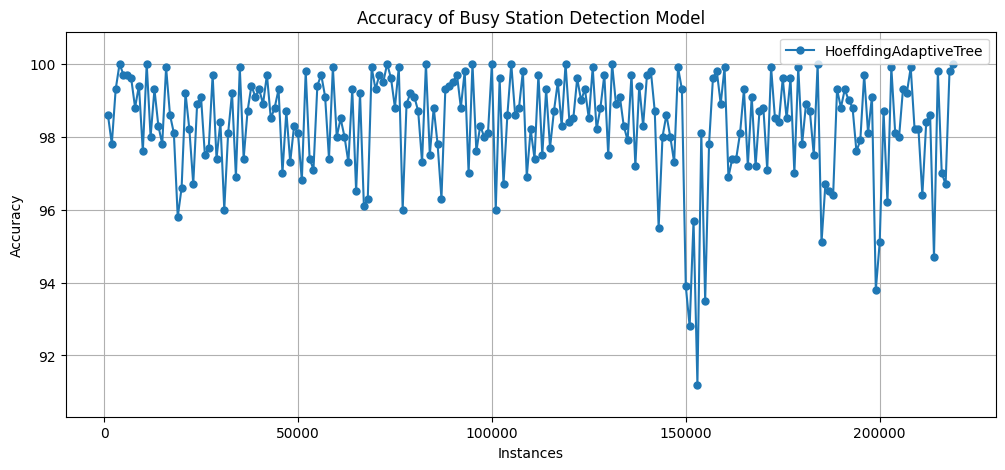

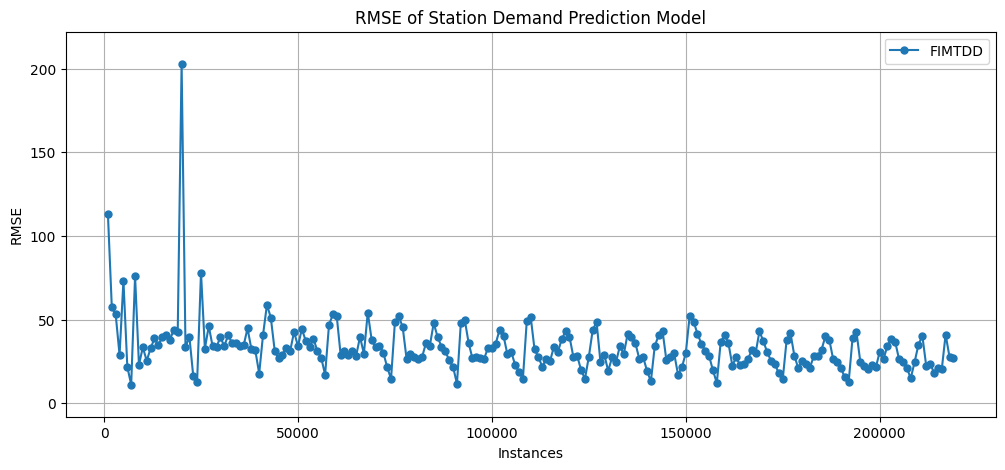

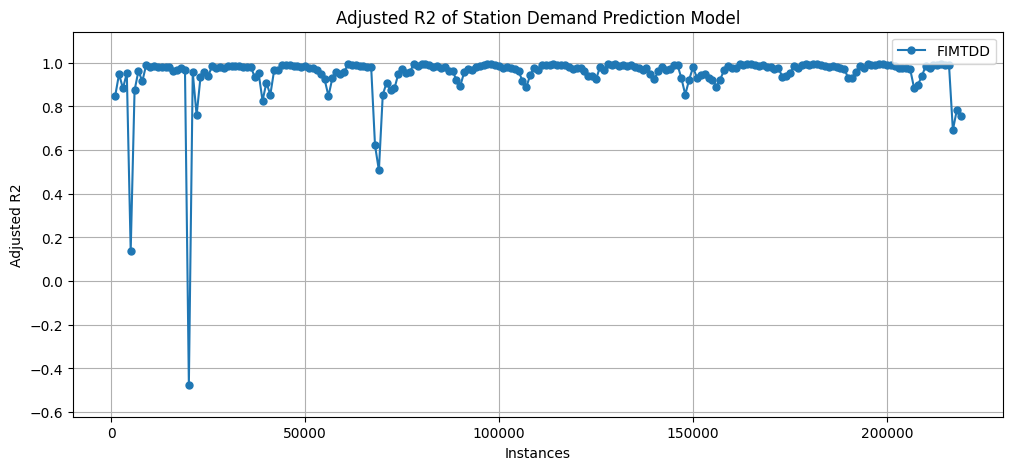

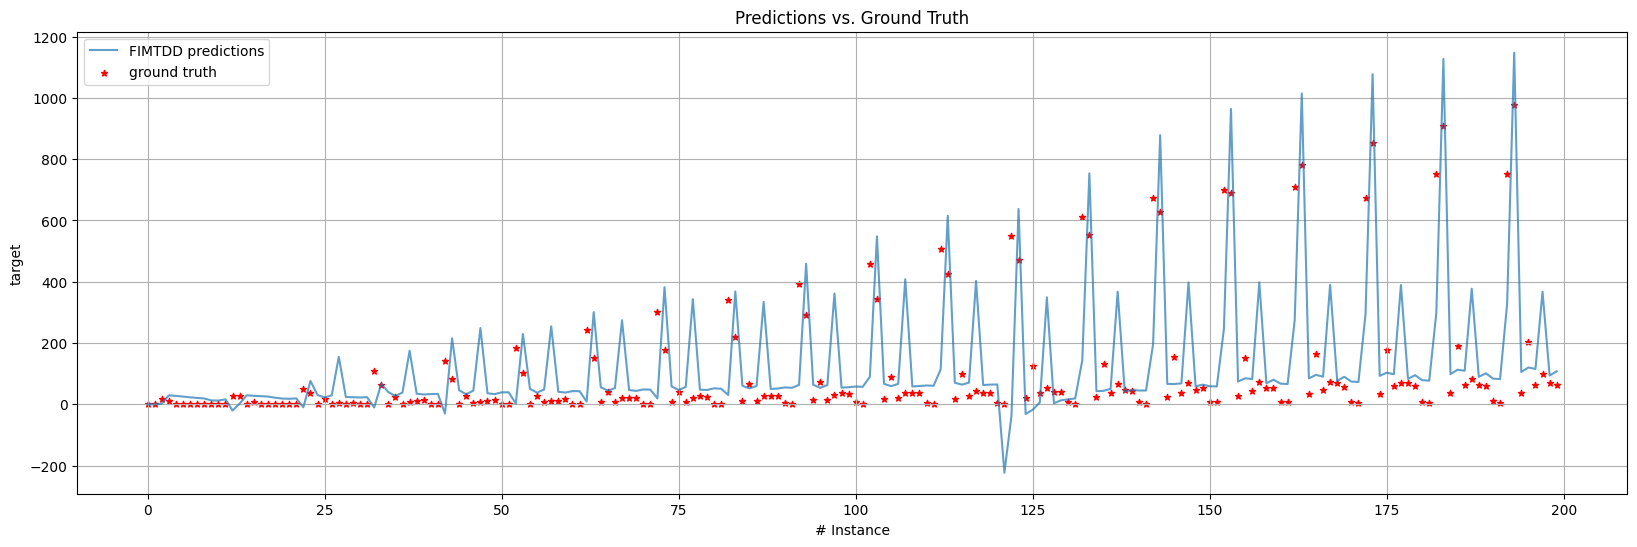

Starting real-time recommendation system simulation using 5min data...
Start time not specified, will simulate from 2024-03-13 14:05:00

=== Time: 2024-03-13 14:05:00 ===
Detected 1 busy stations: ['Avenida Vale Do Tororo 327 Salvador - Bahia 40050 Brasil']...
For station Avenida Vale Do Tororo 327 Salvador - Bahia 40050 Brasil - 43768720 
Recommended alternative station: Avenida Vasco da Gama 4274 - Brotas Salvador - BA Brasil - 44784438 
Distance: 843m

=== Time: 2024-03-13 14:10:00 ===
Detected 1 busy stations: ['Avenida Vale Do Tororo 327 Salvador - Bahia 40050 Brasil']...
For station Avenida Vale Do Tororo 327 Salvador - Bahia 40050 Brasil - 43768720 
Recommended alternative station: Avenida Vasco da Gama 4274 - Brotas Salvador - BA Brasil - 44784438 
Distance: 843m

=== Time: 2024-03-13 14:15:00 ===
Detected 1 busy stations: ['Avenida Vale Do Tororo 327 Salvador - Bahia 40050 Brasil']...
For station Avenida Vale Do Tororo 327 Salvador - Bahia 40050 Brasil - 43768720 
Recommended 

In [4]:
# Data paths
data_path_5min = "./SSA_StopBusTimeSeries_5"
data_path_30min = "./SSA_StopBusTimeSeries_30"

system = StationRecommendationSystem(data_path_5min, data_path_30min)

system.load_and_preprocess_data()

system.evaluate_model_performance("5min")

simulation_5min_results = system.run_real_time_simulation(data_type="5min")

system.generate_simulation_report(simulation_5min_results)

In [5]:
simulation_30min_results = system.run_real_time_simulation(data_type="30min")

system.generate_simulation_report(simulation_30min_results)

Starting real-time recommendation system simulation using 30min data...
Start time not specified, will simulate from 2024-04-04 14:30:00

=== Time: 2024-04-04 14:30:00 ===
Detected 0 busy stations: []...

=== Time: 2024-04-04 15:00:00 ===
Detected 0 busy stations: []...

=== Time: 2024-04-04 15:30:00 ===
Detected 0 busy stations: []...

=== Time: 2024-04-04 16:00:00 ===
Detected 0 busy stations: []...

Simulation Results Summary:
       timestamp  busy_stations_count  recommendations_count
2024-04-04 14:30                    0                      0
2024-04-04 15:00                    0                      0
2024-04-04 15:30                    0                      0
2024-04-04 16:00                    0                      0
